In [46]:
import os
import json
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pathlib
import gzip
import itertools
import random
from collections import namedtuple
from collections import Counter
from scipy import stats
from scipy.stats import norm

%matplotlib inline
plt.rcParams['figure.figsize'] = [16.5, 5]
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

In [2]:
import vcf

Let's define paths to input files and analysis parameters

In [9]:
# A multi-sample VCF file generated by the `trgt merge` command
vcf_path = "/pbi/flash/tmokveld/tmp/egor_ashg_analysis/merged.sorted.vcf.gz"

# Minimum allele multiplicity (remove rare alleles)
min_allele_mult = 20

# TRs with too few alleles will be removed
min_alleles_per_tr = 700

In [10]:
def get_allele_recs(tr_rec):
    all_alleles = []
    for alleles in tr_rec.gts.values():
        all_alleles.extend(alleles)
    return all_alleles


def num_samples_with_gt(tr_rec):
    return len([als for als in rec.gts.values() if als])

In [37]:
def get_size_poly(alleles):
    score = len(set(len(a.seq) for a in alleles))
    return score

In [38]:
def get_frequent_alleles(alleles, min_allele_mult):
    seqs = [a.seq for a in alleles]
    freq_seqs = set(seq for seq, count in Counter(seqs).items() if count >= min_allele_mult)
    return [a for a in alleles if a.seq in freq_seqs]

In [44]:
TrSummary = namedtuple("TrSummary", "trid size_poly")

summary_table = []
num_skipped = 0

for index, rec in enumerate(vcf.get_rec(vcf_path)):
    alleles = get_allele_recs(rec)
    alleles = get_frequent_alleles(alleles, min_allele_mult)
    if len(alleles) < min_alleles_per_tr:
        num_skipped += 1
        continue
    
    size_poly = get_size_poly(alleles)
    summary = TrSummary(trid=rec.trid, size_poly=size_poly)
    summary_table.append(summary)

    
print(f"Number of TRs skipped: {num_skipped} ({100 * num_skipped / (index + 1):.2f}%)")

Number of TRs skipped: 36149 (13.24%)


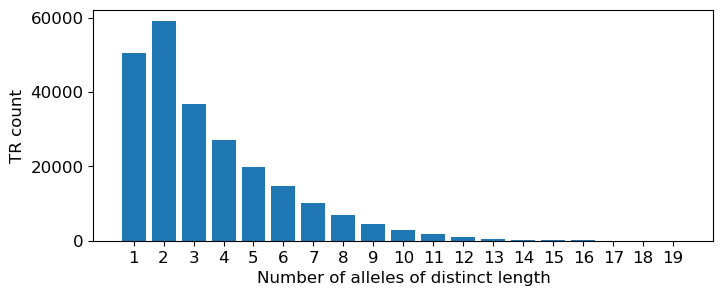

In [64]:
def plot_bars(ax, values):
    value_to_count = dict(Counter(values))
    max_value = max(value_to_count.keys())
    xs = list(range(1, max_value + 1))
    ys = [value_to_count.get(x, 0) for x in xs]
    ax.bar(xs, ys)
    ax.set_xlabel("Number of alleles of distinct length")
    ax.set_ylabel("TR count")
    ax.set_xticks(xs)
    ax.set_xticklabels(xs)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 3))

values = [row.size_poly for row in summary_table]
plot_bars(ax, values)